# Creating YOLO data annotations for ultralytics


## Introduction
The data annotations for ultralytics require the following structure:
```
data/
    - images/
        - train/
            - image1.jpg
            - image2.jpg
            - ...
        - val/
            - image1.jpg
            - image2.jpg
            - ...
        - test/
            - image1.jpg
            - image2.jpg
            - ...
    - labels/
        - train/
            - image1.txt
            - image2.txt
            - ...
        - val/
            - image1.txt
            - image2.txt
            - ...
        - test/
            - image1.txt
            - image2.txt
            - ...
dataset.yaml
```
Additionally, the dataset.yaml file should contain the following structure:
```yaml
path: ../images
train: ../images/train
val: ../images/val
test: ../images/test

nc: 1
names: ['haz_sign']
```


## Algorithm
1. Load the lable dataset
2. Filter sources by locally available videos
3. Create the dataset structure
4. Loop through the videos and create the images and labels per frame that contains the bounding boxes
5. Save the images and labels in the dataset structure


In [1]:
import kagglehub
import pandas as pd
import os
import cv2
import random
import matplotlib.pyplot as plt

c:\Users\stani\Documents\Code\Python\HIN\UN-number-detection\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
distribution = [('train', 0.8), ('test', 0.1), ('val', 0.1)]

In [3]:
path = kagglehub.dataset_download("stanislavlevendeev/hazmat-detection")
video_directory = os.environ["PATH_TO_DATA"]
print("Path to dataset files:", path)
print("Path to video files:", video_directory)

Path to dataset files: C:\Users\stani\.cache\kagglehub\datasets\stanislavlevendeev\hazmat-detection\versions\13
Path to video files: C:/Users/stani/Documents/WagonVideos


At first we are looking at the videos that are labled by grouping the labels into sources. We will then create the annotations for the videos in the format required by ultralytics.

In [4]:
df = pd.read_csv(path + "/labels_dataframe.csv")
videos = df["Source"].unique()
videos

array(['1690279852.mp4', '1690281365.mp4', '1692830440.mp4',
       '1690801380.mp4', '1691487366.mp4', '1692875102.mp4',
       '1692945482.mp4', '1693811855.mp4', '1693954819.mp4',
       '1693805101.mp4', '1693820172.mp4', '1692787289.mp4',
       '1691496786.mp4', '1692872075.mp4', '1693308534.mp4',
       '1693308657.mp4', '1693309263.mp4', '1693820241.mp4',
       '1693820504.mp4', '1693820904.mp4', '1696009577.mp4',
       '1696374314.mp4', '1696416413.mp4', '1696441496.mp4'], dtype=object)

In [5]:
# get unique task source pairs from the dataframe
unique_tasks = df.drop_duplicates(subset=["Job Id", "Source", "Relative Frame"])
unique_tasks.count()

Task ID           9551
Task Name         9551
Job Id            9551
Source            9551
Frames            9551
Absolute Frame    9551
Relative Frame    9551
XTL               9551
YTL               9551
XBR               9551
YBR               9551
Code              9551
Issue             3421
dtype: int64

Consequently, we will filter the unique videos for which labels are created by these that are available locally.

In [6]:
available_videos = os.listdir(video_directory)
available_videos = [video for video in available_videos if video.endswith(".mp4")]
available_videos = [video for video in available_videos if video in videos]
available_videos

['1690281365.mp4', '1692830440.mp4', '1696009577.mp4']

In [7]:
total_frames = df[df["Source"].isin(available_videos)].count()["Task ID"]
total_frames

np.int64(950)

In [8]:
def createYOLODataAnnotation(
    path=None,
    label_name=None,
    classId=None,
    img_width=0,
    img_height=0,
    rows=None
):
    #if already exists, skip
    if os.path.exists(os.path.join(path, label_name)):
        return
    os.makedirs(path, exist_ok=True)
    if not classId or classId == 0:
        with open(os.path.join(path, label_name), "w") as f:
            f.write(f"")
        return
    lable = ''
    for index, row in rows.iterrows():
        x_center = (row['XTL'] + row["XBR"]) / 2 / img_width
        y_center = (row['YTL'] + row['YBR']) / 2 / img_height
        width = (row["XBR"] - row['XTL']) / img_width
        height = (row['YBR'] - row['YTL']) / img_height
        lable += f"0 {x_center} {y_center} {width} {height}\n"
    with open(os.path.join(path, label_name), "w") as f:
        f.write(lable)

frames_dir = path + "/images/"
os.makedirs(frames_dir, exist_ok=True)

def saveFrame(video_name="", frame_num=0, frame=None, frames_dir=frames_dir):
    # if already exists, skip
    if os.path.exists(f"{frames_dir}/{video_name}_{frame_num}.jpg"):
        return
    if frame is None:
        return
    frame_index = str(frame_num).zfill(5)
    frame_name = f"{video_name}_{frame_index}.jpg"
    cv2.imwrite(f"{frames_dir}/{frame_name}", frame)

In [88]:
frame_count = 0
dataset = 0
switch_frame = distribution[dataset][1] * total_frames.astype(int)
print(f"Switched to {distribution[dataset][0]} dataset with {switch_frame} frames")
labels_dir = os.path.join(path, "yolo", "labels", distribution[dataset][0])
frames_dir = os.path.join(path, "yolo", "images", distribution[dataset][0])
os.makedirs(labels_dir, exist_ok=True)
os.makedirs(frames_dir, exist_ok=True)
for video in available_videos:
    video_path = video_directory + "/" + video
    if os.path.exists(video_path) == False:
        print(f"File {video_path} not found")
        continue
    processed_source = video.split(".")[0]
    # Open video file
    cap = cv2.VideoCapture(video_path)
    number_of_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"File {video_path} has {number_of_frames} frames")
    video_labels = df[df["Source"] == video]
    frame_idx = 0
    # save each frame and .txt file with labels
    while frame_idx < number_of_frames:
        frame_idx += 1
        if frame_count > switch_frame:
            dataset += 1
            switch_frame += distribution[dataset][1] * total_frames.astype(int)
            labels_dir = os.path.join(path, "yolo", "labels", distribution[dataset][0])
            frames_dir = os.path.join(path, "yolo", "images", distribution[dataset][0])
            os.makedirs(frames_dir, exist_ok=True)
            os.makedirs(labels_dir, exist_ok=True)
            print(f"Switched to {distribution[dataset][0]} dataset with {switch_frame} frames")
        ret, frame = cap.read()  # Read each frame
       
        if not ret:
            break  # End of video
        img_height, img_width, _ = frame.shape
        img_height = int(img_height)
        img_width = int(img_width)
        label_frames = video_labels[video_labels["Relative Frame"] == frame_idx-1]
        isObject = frame_idx-1 in video_labels["Relative Frame"].values
        if(not isObject):
                continue
            # Save frame
        saveFrame(processed_source, frame_idx-1, frame, frames_dir)
        frame_index = str(frame_idx-1).zfill(5)
        label_name = f"{processed_source}_{frame_index}.txt"
        createYOLODataAnnotation(
            path=labels_dir,
            label_name=label_name,
            classId=1 if isObject else None,
            img_height=img_height,
            img_width=img_width,
            rows=label_frames
        )
        frame_count += label_frames.count()["XTL"]
    print(f"Created frames and labels for video {video_path}: Progress {frame_count}/{total_frames}")
    cap.release()

Switched to train dataset with 760.0 frames
File C:/Users/stani/Documents/WagonVideos/1690281365.mp4 has 733 frames
Created frames and labels for video C:/Users/stani/Documents/WagonVideos/1690281365.mp4: Progress 198/950
File C:/Users/stani/Documents/WagonVideos/1692830440.mp4 has 4965 frames
Created frames and labels for video C:/Users/stani/Documents/WagonVideos/1692830440.mp4: Progress 359/950
File C:/Users/stani/Documents/WagonVideos/1696009577.mp4 has 4640 frames
Switched to test dataset with 855.0 frames
Switched to val dataset with 950.0 frames
Created frames and labels for video C:/Users/stani/Documents/WagonVideos/1696009577.mp4: Progress 950/950


## Validation of the data annotations
Once data annotations is created these need to be checked for correctness.

In [32]:

# Function to draw rectangles on an image
def draw_rectangles(image_path, annotation_path, issue = None):
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width, _ = image.shape

    # Read the annotation file
    with open(annotation_path, "r") as f:
        lines = f.readlines()
        for line in lines:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            # Convert from YOLO format to bounding box coordinates
            x_min = int((x_center - width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            x_max = int((x_center + width / 2) * img_width)
            y_max = int((y_center + height / 2) * img_height)
            # Draw the rectangle
            #change color for each new rectangle so that they are distinguishable the first element is the color in BGR format
            #Display issue
            if issue != None and issue != "":
                cv2.putText(image, str(issue), (x_min, y_min), cv2.FONT_HERSHEY_SIMPLEX, 1,  (0, 255, 50), 2)
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            
    
    # Convert BGR image to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image using matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


Number of images: 950
Random image: 1337
Random image: C:\Users\stani\.cache\kagglehub\datasets\stanislavlevendeev\hazmat-detection\versions\13\yolo\images\train\1690281365_00607.jpg


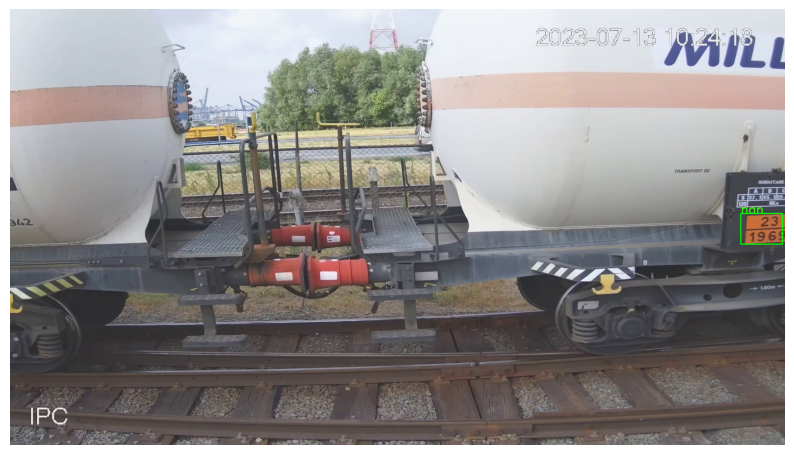

In [33]:

# Directory containing images and annotations
image_dir = os.path.join(path, "yolo", "images")
annotation_dir = os.path.join(path, "yolo", "labels")


# Get a list of all images
images = df[df["Source"].isin(available_videos)]
print("Number of images:", len(images))
dist = 'train'
# Pick a random image
random_image = random.choice(images["Absolute Frame"].values)
print("Random image:", random_image)
frame_info = images[images["Absolute Frame"] == random_image]
image_name = frame_info["Source"].values[0].replace('.mp4','') + "_" + str(frame_info["Relative Frame"].values[0]).zfill(5) + ".jpg"
image_path = os.path.join(image_dir, dist, image_name)
if(not os.path.isfile(image_path)):
    dist = 'test'
    image_path = os.path.join(image_dir, dist, image_name)
if(not os.path.isfile(image_path)):
    dist = 'val'
    image_path = os.path.join(image_dir, dist, image_name)
if( os.path.isfile(image_path)):
    print("Random image:", image_path)
    # Corresponding annotation file
    annotation_filename = frame_info["Source"].values[0].replace('.mp4','') + "_" + str(frame_info["Relative Frame"].values[0]).zfill(5) + ".txt"
    annotation_path = os.path.join(annotation_dir,dist, annotation_filename)

    # Draw rectangles on the random image
    draw_rectangles(image_path, annotation_path, frame_info["Issue"].values[0])
else:
    print("No image found:" + image_path)


In [70]:
print(frame_count)

950
